In [1]:
import os
import time
import warnings
from pathlib import Path

import numpy as np
import pandas as pd
import polars as pl
import safetensors
import seaborn as sns
import torch
import transformers
from datasets import Dataset
from hydra import compose, initialize
from matplotlib import pyplot as plt
from omegaconf import OmegaConf
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
from src.seed import seed_everything
from torch import nn
from torch.utils.data.dataloader import DataLoader
from tqdm.auto import tqdm
from transformers import (
    AutoConfig,
    AutoModel,
    AutoModelForSequenceClassification,
    AutoTokenizer,
    DataCollatorWithPadding,
    PreTrainedModel,
    Trainer,
    TrainingArguments,
)
from transformers.modeling_outputs import SequenceClassifierOutput

warnings.filterwarnings("ignore")


with initialize(config_path="config", version_base=None):
    cfg = compose(config_name="config")
    cfg.exp_number = Path().resolve().name

print(OmegaConf.to_yaml(cfg, resolve=True))

seed_everything(cfg.seed)


bert:
  params:
    model_path: microsoft/deberta-v3-large
    metric: auc
    max_length: 192
    fp16: true
    learning_rate: 2.0e-05
    epochs: 2
    per_device_train_batch_size: 8
    per_device_eval_batch_size: 8
    steps: 100
    lr_scheduler_type: cosine
    weight_decay: 0.01
exp_number: '015'
run_name: base
data:
  data_root: ../../data
  results_root: ../../results
  train_path: ../../data/train.csv
  cloth_path: ../../data/clothing_master.csv
  test_path: ../../data/test.csv
  sample_submission_path: ../../data/sample_submission.csv
  results_dir: ../../results/015/base
seed: 42
n_splits: 5
target: Recommended IND



### Auxiliary Lossの実装
- Ratingを回帰で予測する補助タスクを追加

### データの準備


In [2]:
train_df = pl.read_csv(cfg.data.train_path, try_parse_dates=True)
test_df = pl.read_csv(cfg.data.test_path, try_parse_dates=True)
cloth_df = pl.read_csv(cfg.data.cloth_path, try_parse_dates=True)

train_df = train_df.join(cloth_df, on="Clothing ID", how="left")
test_df = test_df.join(cloth_df, on="Clothing ID", how="left")

skf = StratifiedKFold(n_splits=cfg.n_splits, shuffle=True, random_state=cfg.seed)


In [3]:
DEBUG = False

if DEBUG:
    train_df = train_df.head(100)


def preprocess_text(df: pl.DataFrame) -> pl.DataFrame:
    df = df.with_columns(
        pl.concat_str(
            [
                pl.col("Age").fill_null("none"),
                pl.lit("-Year-Old's Review of "),
                pl.col("Class Name").fill_null("none"),
                pl.lit(" [SEP] "),
                pl.lit("TITLE: "),
                pl.col("Title").fill_null("none"),
                pl.lit(" [SEP] "),
                pl.lit("Review Text: "),
                pl.col("Review Text").fill_null("none"),
                pl.lit(" [SEP] "),
                pl.lit("Positive Feedback Count: "),
                pl.col("Positive Feedback Count").fill_null("none"),
            ]
        ).alias("prompt")
    )
    return df


train_df = preprocess_text(train_df)
test_df = preprocess_text(test_df)

# labels, labels_aux(1を引いて0~4にする)列を作成
# 0~4にしないと、aux_lossが計算の際エラーが出る
train_df = train_df.with_columns(pl.col(cfg.target).cast(pl.Int8).alias("labels"))
train_df = train_df.with_columns((pl.col("Rating") - 1).cast(pl.Int8).alias("labels_aux"))
train_df.head(3)


Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name,prompt,labels,labels_aux
i64,i64,str,str,i64,i64,i64,str,str,str,str,i8,i8
0,25,"""3-season skirt!""","""Adorable, well-made skirt! lin…",5,1,4,"""General""","""Bottoms""","""Skirts""","""25-Year-Old's Review of Skirts…",1,4
0,39,"""Very cute""","""Love the asymmetrical hem. wai…",5,1,0,"""General""","""Bottoms""","""Skirts""","""39-Year-Old's Review of Skirts…",1,4
0,42,"""Beautiful! fruns small for typ…","""I love this skirt! i wasn't su…",5,1,5,"""General""","""Bottoms""","""Skirts""","""42-Year-Old's Review of Skirts…",1,4


In [4]:
train_df["labels_aux"].value_counts()


labels_aux,count
i8,u32
4,5552
2,1240
1,671
0,362
3,2175


In [5]:
# prompt例
train_df["prompt"][0]


"25-Year-Old's Review of Skirts [SEP] TITLE: 3-season skirt! [SEP] Review Text: Adorable, well-made skirt! lined and very slimming. i had to size up b/c it runs a bit snug around the waist. however, it's worth it b/c this will match many long and short sleeve tops! [SEP] Positive Feedback Count: 4"

In [6]:
# tokenizer
tokenizer = AutoTokenizer.from_pretrained(cfg.bert.params.model_path)


def tokenize(sample):
    return tokenizer(sample["prompt"], max_length=cfg.bert.params.max_length, truncation=True)


In [7]:
# token長を確認 --> max_length 192で大丈夫
print(
    f"train_df: {train_df.select(pl.col('prompt').map_elements(lambda x: len(tokenizer(x)['input_ids']))).max().item()}"
)
print(
    f"test_df: {test_df.select(pl.col('prompt').map_elements(lambda x: len(tokenizer(x)['input_ids']))).max().item()}"
)


train_df: 185
test_df: 184


### 学習

In [8]:
# 補助タスクを追加したカスタムモデル
class Atma17CustomModel(PreTrainedModel):
    config_class = AutoConfig

    def __init__(self, model_path: str) -> None:
        model_config = self.config_class.from_pretrained(model_path)
        model_config.num_labels = 2  # 2値分類だから2
        model_config.output_hidden_states = True
        super().__init__(config=model_config)
        self.model_config = model_config
        self.model = AutoModelForSequenceClassification.from_pretrained(model_path, config=model_config)

        # Rating for classification
        self.aux_head = nn.Linear(self.model.config.hidden_size, 5)

    def forward(
        self,
        input_ids: torch.Tensor,
        labels: torch.Tensor | None = None,
        attention_mask: torch.Tensor | None = None,
    ) -> SequenceClassifierOutput:
        # 通常の2値分類の出力を取得
        out = self.model(input_ids=input_ids, labels=labels, attention_mask=attention_mask)

        # 最終層の[CLS]トークンの出力を取り出して回帰headへの入力に使用
        aux_out = self.aux_head(out.hidden_states[-1][:, 0])

        # 回帰の出力を追加して返す
        output = SequenceClassifierOutput(
            logits=out.logits,
            hidden_states=None,
            attentions=None,
            loss=out.loss,
        )
        output["logits_aux"] = aux_out
        return output


def _test_model() -> None:
    m = Atma17CustomModel(model_path="microsoft/deberta-v3-large")
    i = torch.randint(0, 1000, (8, 256))
    out = m(i, torch.randint(0, 2, (8,)))
    print(f"i.shape: {i.shape}")
    print(f"logits: {out.logits}")
    print(f"logits_aux: {out.logits_aux}")


# 出力テスト
# _test_model()


In [9]:
# AuxLossを計算するカスタムTrainerを作成
loss_fn = nn.CrossEntropyLoss()

# loss_fn_aux = nn.MSELoss()
loss_fn_aux = nn.CrossEntropyLoss()  # Ratingを分類で予測するのでCrossEntropyLossを使う


class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.pop("labels")
        labels_aux = inputs.pop("labels_aux")

        outputs = model(**inputs)
        logits = outputs.get("logits")
        aux_logits = outputs.get("logits_aux")
        loss = loss_fn(logits.view(-1, 2), labels.view(-1))
        loss_aux = loss_fn_aux(aux_logits.view(-1, 5), labels_aux.view(-1))

        return (loss + loss_aux, outputs) if return_outputs else loss + loss_aux


In [11]:
# metricをAUCに変更
def compute_metrics(eval_pred):
    preds, all_labels = eval_pred
    # predsとall_labelsはメインタスクと補助タスクの分のtupleになるので、メインタスクのみの予測値とラベルを取り出す
    if isinstance(all_labels, tuple):
        labels = all_labels[0]
    else:
        labels = all_labels
    if isinstance(preds, tuple):
        preds = preds[0]
    preds = torch.softmax(torch.tensor(preds), dim=1).numpy()
    score = roc_auc_score(labels, preds[:, 1])
    return {"auc": score}


# 実験結果格納用のディレクトリを作成
cfg.run_name = time.strftime("%Y%m%d_%H%M%S")
Path(cfg.data.results_dir).mkdir(exist_ok=True, parents=True)

y_train = train_df[cfg.target].to_numpy()
oof = np.zeros(len(y_train))

for fold, (train_idx, val_idx) in enumerate(skf.split(train_df, y_train)):
    ds_train = Dataset.from_pandas(train_df[train_idx][["prompt", "labels", "labels_aux"]].clone().to_pandas())
    ds_val = Dataset.from_pandas(train_df[val_idx][["prompt", "labels", "labels_aux"]].clone().to_pandas())

    # config = AutoConfig.from_pretrained(cfg.bert.params.model_path, num_labels=2)
    model = Atma17CustomModel(cfg.bert.params.model_path)

    ds_train = ds_train.map(tokenize).remove_columns("prompt")
    ds_val = ds_val.map(tokenize).remove_columns("prompt")

    output_dir = os.path.join(cfg.data.results_dir, f"fold{fold}")

    train_args = TrainingArguments(
        output_dir=output_dir,  # 学習結果の出力ディレクトリ
        fp16=cfg.bert.params.fp16,  # 16ビット浮動小数点演算を使用するかどうか
        learning_rate=cfg.bert.params.learning_rate,  # 学習率
        num_train_epochs=cfg.bert.params.epochs,  # 学習エポック数
        per_device_train_batch_size=cfg.bert.params.per_device_train_batch_size,  # デバイスあたりの訓練バッチサイズ
        per_device_eval_batch_size=cfg.bert.params.per_device_eval_batch_size,  # デバイスあたりの評価バッチサイズ
        gradient_accumulation_steps=4,  # 勾配蓄積ステップ数
        report_to="none",  # レポート出力先（なし）
        evaluation_strategy="steps",  # 評価戦略（ステップごと）
        do_eval=True,  # 評価を行うかどうか
        eval_steps=cfg.bert.params.steps,  # 評価を行うステップ間隔
        save_total_limit=1,  # 保存するモデルの最大数
        save_strategy="steps",  # 保存戦略（ステップごと）
        save_steps=cfg.bert.params.steps,  # モデルを保存するステップ間隔
        logging_steps=cfg.bert.params.steps,  # ログを出力するステップ間隔
        load_best_model_at_end=True,  # 学習終了時に最良のモデルをロードするかどうか
        lr_scheduler_type=cfg.bert.params.lr_scheduler_type,  # 学習率スケジューラーの種類
        metric_for_best_model=cfg.bert.params.metric,  # 最良モデルを判断するための評価指標
        greater_is_better=True,  # 評価指標が大きいほど良いかどうか
        warmup_ratio=0.1,  # ウォームアップの比率
        weight_decay=cfg.bert.params.weight_decay,  # 重み減衰
        save_safetensors=True,  # SafeTensorsフォーマットで保存するかどうか
        seed=cfg.seed,  # 乱数シード
        data_seed=cfg.seed,  # データシャッフル用の乱数シード
        label_names=["labels", "labels_aux"],  # 入力するラベルの名前
    )

    trainer = CustomTrainer(
        model=model,
        args=train_args,
        train_dataset=ds_train,
        eval_dataset=ds_val,
        data_collator=DataCollatorWithPadding(tokenizer),
        tokenizer=tokenizer,
        compute_metrics=compute_metrics,
    )

    trainer.train()

    final_output_dir = f"{cfg.data.results_dir}/fold{fold}/final"
    trainer.save_model(final_output_dir)
    tokenizer.save_pretrained(final_output_dir)

    # predictionはlabelとRatingの予測値のtupleを返すので、labelの予測値のみを取り出す必要あり
    pred = torch.softmax(torch.tensor(trainer.predict(ds_val).predictions[0]), dim=1).numpy()
    oof[val_idx] = pred[:, 1]


Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-large and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/8000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Step,Training Loss,Validation Loss,Auc
100,1.578400,1.064472,0.968624
200,0.991100,1.005897,0.970749
300,0.854400,0.903364,0.972477
400,0.776600,0.873777,0.974546
500,0.809700,0.864598,0.974937


Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-large and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/8000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Step,Training Loss,Validation Loss,Auc
100,1.462800,1.076725,0.958712
200,0.998500,0.909322,0.969684
300,0.899100,0.841906,0.971223
400,0.800800,0.820424,0.972563
500,0.774300,0.810237,0.973485


Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-large and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/8000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Step,Training Loss,Validation Loss,Auc
100,1.531700,1.100989,0.956690
200,0.987100,0.910169,0.969045
300,0.859800,0.943849,0.967762
400,0.782900,0.848714,0.972302
500,0.770100,0.847885,0.972694


Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-large and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/8000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Step,Training Loss,Validation Loss,Auc
100,1.523100,1.185790,0.948995
200,1.017400,1.087713,0.962600
300,0.867100,0.993544,0.964307
400,0.815900,0.870910,0.969444
500,0.805100,0.863303,0.970431


Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-large and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/8000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Step,Training Loss,Validation Loss,Auc
100,1.451500,1.045882,0.964160
200,0.986000,0.949502,0.969411
300,0.871000,0.874171,0.969323
400,0.795900,0.877909,0.971414
500,0.785400,0.859915,0.971602


### Sub


In [12]:
preds = []
for fold in range(cfg.n_splits):
    # ベストステップのモデルを取得
    fold_dir = f"{cfg.data.results_dir}/fold{fold}"
    checkpoint_dirs = [d for d in os.listdir(fold_dir) if d.startswith("checkpoint-")]
    results_dir = os.path.join(fold_dir, checkpoint_dirs[0])
    print(f"{results_dir=}")

    # カスタムモデルを採用しているので重みをロードしてくる必要がある
    model = Atma17CustomModel(cfg.bert.params.model_path)
    msg = model.load_state_dict(safetensors.torch.load_file(results_dir + "/model.safetensors"))
    print(msg)

    ds_test = Dataset.from_pandas(test_df.select("prompt").clone().to_pandas())
    ds_test = ds_test.map(tokenize).remove_columns("prompt")

    test_args = TrainingArguments(
        output_dir=cfg.data.results_dir,
        per_device_eval_batch_size=cfg.bert.params.per_device_eval_batch_size,
        do_predict=True,
        dataloader_drop_last=False,
    )

    trainer = Trainer(
        model=model,
        args=test_args,
        data_collator=DataCollatorWithPadding(tokenizer),
        tokenizer=tokenizer,
    )
    predictions = torch.softmax(torch.tensor(trainer.predict(ds_test).predictions[0]), dim=1).numpy()
    preds.append(predictions[:, 1])

pred = np.mean(preds, axis=0)


results_dir='../../results/015/20240905_164359/fold0/checkpoint-500'


Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-large and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


<All keys matched successfully>


Map:   0%|          | 0/11155 [00:00<?, ? examples/s]

results_dir='../../results/015/20240905_164359/fold1/checkpoint-500'


Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-large and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


<All keys matched successfully>


Map:   0%|          | 0/11155 [00:00<?, ? examples/s]

results_dir='../../results/015/20240905_164359/fold2/checkpoint-500'


Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-large and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


<All keys matched successfully>


Map:   0%|          | 0/11155 [00:00<?, ? examples/s]

results_dir='../../results/015/20240905_164359/fold3/checkpoint-500'


Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-large and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


<All keys matched successfully>


Map:   0%|          | 0/11155 [00:00<?, ? examples/s]

results_dir='../../results/015/20240905_164359/fold4/checkpoint-500'


Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-large and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


<All keys matched successfully>


Map:   0%|          | 0/11155 [00:00<?, ? examples/s]

In [13]:
# 提出
sub_df = pl.read_csv(cfg.data.sample_submission_path)
sub_df = sub_df.with_columns(pl.Series(pred).alias("target"))
sub_df.write_csv(os.path.join(cfg.data.results_dir, f"{cfg.run_name}_submission.csv"))
sub_df.head()


target
f32
0.998545
0.4093
0.997561
0.079355
0.997852


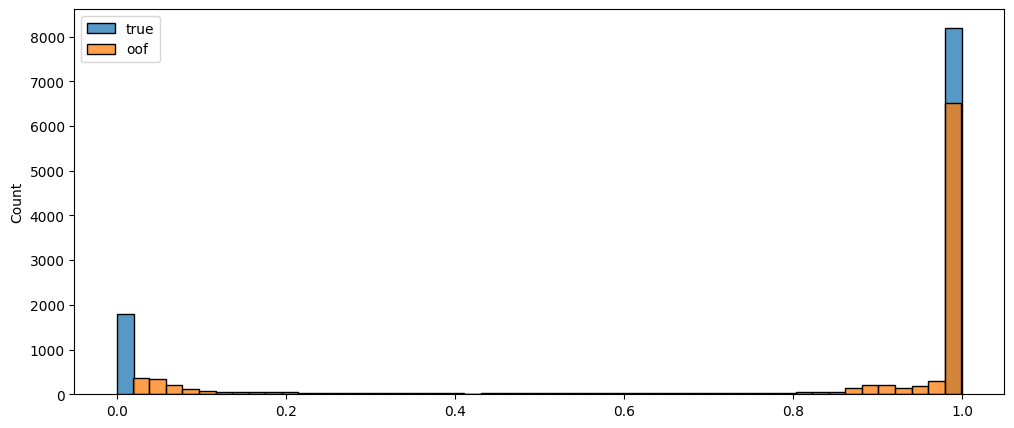

In [14]:
# oof
fig, ax = plt.subplots(figsize=(12, 5))
sns.histplot(y_train, bins=50)
sns.histplot(oof, bins=50)
plt.legend(["true", "oof"])
plt.show()
fig.savefig(f"{cfg.data.results_dir}/oof_hist.png")
